In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycwt as wavelet
from scipy import signal
import yfinance as yf

import warnings

warnings.filterwarnings('ignore')

# data preprocessing 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

(740, 1)
(740, 1)


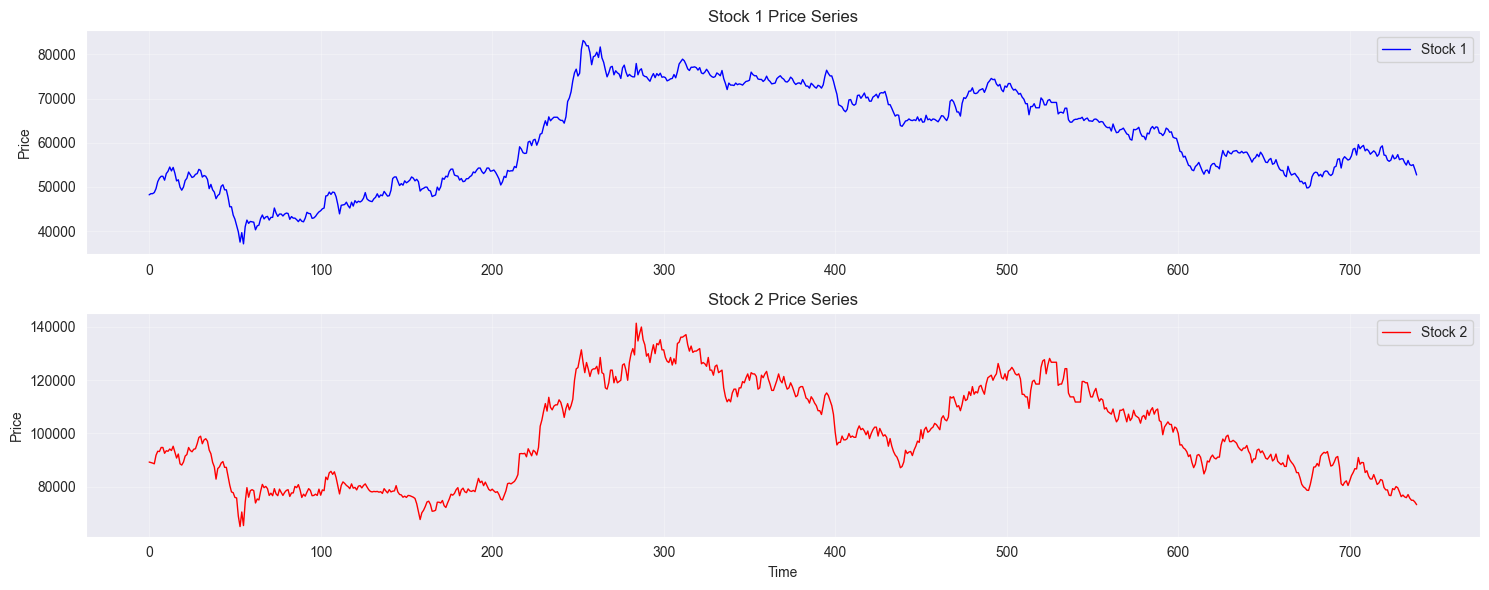

In [13]:
# 두 주식의 데이터 다운로드
stock1_data = yf.download('005930.KS', start='2020-01-01', end='2023-01-01')  # 삼성전자
stock2_data = yf.download('000660.KS', start='2020-01-01', end='2023-01-01')  # SK하이닉스

# 종가 데이터 추출
stock1_close = stock1_data['Close'].values
stock2_close = stock2_data['Close'].values
time_real = np.arange(len(stock1_close))
time_len=len(stock1_close)

# 로그 수익률 계산
stock1_returns = np.log(stock1_close[1:] / stock1_close[:-1])
stock2_returns = np.log(stock2_close[1:] / stock2_close[:-1])

print(stock1_close.shape)
print(stock2_close.shape)

# 데이터 시각화
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(time_real, stock1_close, 'b-', label='Stock 1', linewidth=1)
plt.title('Stock 1 Price Series')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(time_real, stock2_close, 'r-', label='Stock 2', linewidth=1)
plt.title('Stock 2 Price Series')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# individual_wavelet_spectrum

In [17]:
def calculate_individual_wavelet_spectrum(signal, dt=1.0, dj=1/12, s0=None, J=None, 
                                        wavelet_type='morlet'):
    """
    개별 신호의 웨이브렛 스펙트럼 계산 (수정된 버전)
    
    Parameters:
    -----------
    signal : array-like
        분석할 시계열 데이터
    dt : float
        샘플링 간격 (기본값: 1.0 - 일일 데이터)
    dj : float
        스케일 해상도 (기본값: 1/12 - 논문 기준)
    s0 : float
        최소 스케일 (None이면 2*dt로 자동 설정)
    J : int
        스케일 개수 (None이면 자동 계산)
    wavelet_type : str
        웨이브렛 타입 (기본값: 'morlet')
    
    Returns:
    --------
    power : ndarray
        웨이브렛 파워 스펙트럼
    period : ndarray
        주기 배열
    coi : ndarray
        Cone of influence
    W : ndarray
        웨이브렛 변환 계수
    """
    
    # 입력 데이터 검증
    signal = np.array(signal)
    if len(signal) < 4:
        raise ValueError("신호 길이가 너무 짧습니다. 최소 4개 이상의 데이터 포인트가 필요합니다.")
    
    # NaN 값 처리
    if np.any(np.isnan(signal)):
        print("경고: 신호에 NaN 값이 포함되어 있습니다. 선형 보간으로 처리합니다.")
        signal = pd.Series(signal).interpolate().values
    
    # 웨이브렛 선택 (논문에서 사용된 Morlet 웨이브렛)
    if wavelet_type.lower() == 'morlet':
        mother = wavelet.Morlet(6)  # ω₀ = 6 (논문 기준)
    elif wavelet_type.lower() == 'paul':
        mother = wavelet.Paul(4)
    elif wavelet_type.lower() == 'dog':
        mother = wavelet.DOG(2)
    else:
        mother = wavelet.Morlet(6)  # 기본값
    
    # 기본 파라미터 설정 (논문 기준)
    if s0 is None:
        s0 = 2 * dt  # 최소 스케일
    if J is None:
        # 안전한 J 계산
        max_J = int(np.log2(len(signal) * dt / s0) / dj)
        J = min(max_J, 100)  # 최대 100개 스케일로 제한
    
    try:
        # 연속 웨이브렛 변환 수행
        W, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(
            signal, dt, dj=dj, s0=s0, J=J, wavelet=mother
        )
        
        # 파워 스펙트럼 계산
        power = (np.abs(W)) ** 2
        period = 1 / freqs
        
        print(f"웨이브렛 변환 성공: {len(signal)}개 데이터 포인트, {len(freqs)}개 주파수 대역")
        
    except Exception as e:
        print(f"웨이브렛 변환 중 오류 발생: {e}")
        # 더 보수적인 파라미터로 재시도
        J = min(J // 2, 50)
        s0 = 4 * dt
        
        W, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(
            signal, dt, dj=dj, s0=s0, J=J, wavelet=mother
        )
        power = (np.abs(W)) ** 2
        period = 1 / freqs
        
        print(f"보수적 파라미터로 재계산 완료: J={J}, s0={s0}")
    
    return power, period, coi, W


# plot individual wavelet

In [18]:
def plot_individual_wavelet_spectrum(time, period, power, coi, title="Wavelet Spectrum"):
    """
    개별 웨이브렛 스펙트럼 시각화 (개선된 버전)
    """
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # 시간-주기 범위 설정
    extent = [time.min(), time.max(), np.log2(period.min()), np.log2(period.max())]
    
    # 파워 스펙트럼 정규화 (더 나은 시각화를 위해)
    power_normalized = power / np.max(power)
    
    # 파워 스펙트럼 플롯 (로그 스케일)
    im = ax.imshow(np.log2(power_normalized + 1e-12), extent=extent, cmap='jet', 
                   aspect='auto', origin='lower', vmin=-10, vmax=0)
    
    # Cone of influence 표시
    ax.plot(time, np.log2(coi), 'k--', linewidth=2, label='Cone of Influence')
    ax.fill_between(time, np.log2(coi), np.log2(period.max()), 
                    alpha=0.3, color='white', label='COI 영역')
    
    # 컬러바 추가
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Normalized Power (log₂)', fontsize=12)
    
    # 축 레이블 및 제목
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('log₂(Period)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Y축 눈금 설정 (주기로 표시)
    yticks = np.arange(np.ceil(np.log2(period.min())), 
                      np.floor(np.log2(period.max())) + 1)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f'{2**int(y)}' for y in yticks])
    
    # 주요 주기 표시선 추가
    important_periods = [2, 5, 10, 20, 50, 100]  # 일 단위
    for p in important_periods:
        if period.min() <= p <= period.max():
            ax.axhline(y=np.log2(p), color='white', linestyle=':', alpha=0.7)
            ax.text(time.max() * 0.02, np.log2(p), f'{p}일', 
                   color='white', fontsize=10, va='center')
    
    # 범례 추가
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

# wavelet coherence calculation

In [4]:
def calculate_wavelet_coherence(signal1, signal2, dt=1.0, dj=1/12, s0=None, J=None, 
                               significance_level=0.95, wavelet_type='morlet'):
    """
    두 시계열 간의 wavelet coherence 계산
    
    Parameters:
    -----------
    signal1, signal2 : array-like
        분석할 두 시계열 데이터
    dt : float
        샘플링 간격
    dj : float
        스케일 해상도 (작을수록 높은 해상도)
    s0 : float
        최소 스케일 (None이면 2*dt)
    J : int
        스케일 개수 (None이면 자동 계산)
    significance_level : float
        유의수준
    wavelet_type : str
        사용할 웨이블릿 타입
    
    Returns:
    --------
    WCT : ndarray
        Wavelet coherence transform
    aWCT : ndarray
        Average wavelet coherence
    coi : ndarray
        Cone of influence
    freq : ndarray
        주파수 배열
    sig : ndarray
        유의성 레벨
    """
    
    # 웨이블릿 선택
    if wavelet_type.lower() == 'morlet':
        mother = wavelet.Morlet(6)  # 논문에서 사용된 Morlet 웨이블릿
    else:
        mother = wavelet.Morlet(6)
    
    # 기본 파라미터 설정
    if s0 is None:
        s0 = 2 * dt
    if J is None:
        J = int(np.log2(len(signal1) * dt / s0) / dj)
    
    # Wavelet coherence 계산
    WCT, aWCT, coi, freq, sig = wavelet.wct(
        signal1, signal2, dt, dj=dj, s0=s0, J=J, 
        significance_level=significance_level, 
        wavelet=mother, normalize=True
    )
    
    return WCT, aWCT, coi, freq, sig

# Wavelet coherence 계산 실행
dt = time[1] - time[0]
WCT, aWCT, coi, freq, sig = calculate_wavelet_coherence(stock1, stock2, dt=dt)

print(f"Wavelet Coherence Transform shape: {WCT.shape}")
print(f"Frequency range: {freq.min():.4f} - {freq.max():.4f}")
print(f"Time range: {time.min():.2f} - {time.max():.2f}")


Calculating wavelet coherence significance


100%|██████████| 300/300 [11:59<00:00,  2.40s/it]

Wavelet Coherence Transform shape: (108, 1000)
Frequency range: 0.2501 - 120.8807
Time range: 0.00 - 4.00


# plot coherence

TypeError: Input z must be 2D, not 1D

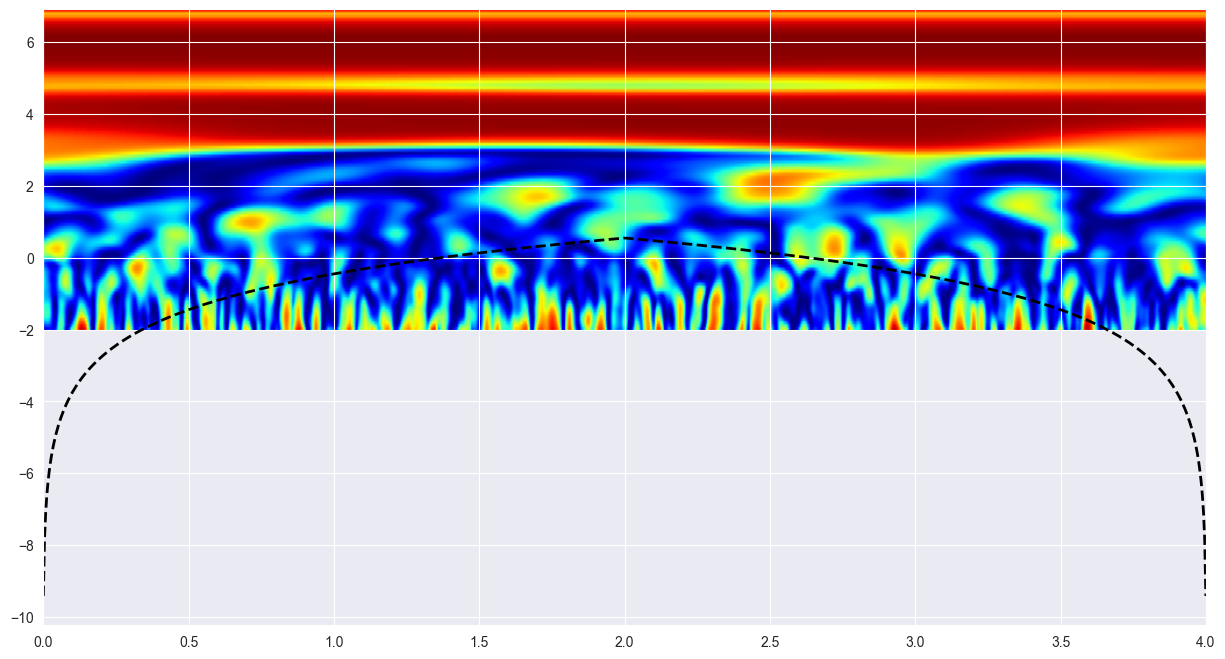

In [5]:
def plot_wavelet_coherence_spectrum(time, freq, WCT, coi, sig, 
                                  title="Wavelet Coherence Spectrum"):
    """
    Wavelet coherence 스펙트럼 시각화
    """
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # 시간-주파수 범위 설정
    extent = [time.min(), time.max(), np.log2(freq.min()), np.log2(freq.max())]
    
    # Coherence 스펙트럼 플롯
    im = ax.imshow(np.abs(WCT), extent=extent, cmap='jet', aspect='auto', 
                   origin='lower', vmin=0, vmax=1)
    
    # Cone of influence 표시
    ax.plot(time, np.log2(coi), 'k--', linewidth=2, label='Cone of Influence')
    
    # 유의성 레벨 컨투어
    ax.contour(time, np.log2(freq), sig, levels=[1], colors='white', 
               linewidths=2, linestyles='solid')
    
    # 컬러바 추가
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Wavelet Coherence', fontsize=12)
    
    # 축 레이블 및 제목
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('log₂(Period)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Y축 눈금 설정 (주기로 표시)
    yticks = np.arange(np.ceil(np.log2(freq.min())), 
                      np.floor(np.log2(freq.max())) + 1)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f'{2**int(y)}' for y in yticks])
    
    # 범례 추가
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

# 스펙트럼 시각화
fig, ax = plot_wavelet_coherence_spectrum(time, freq, WCT, coi, sig)
